In [25]:
import numpy as np
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import time
import cv2
from cameraCoppelia import CameraCoppelia, world_to_pixel_coordinates, pixel_to_world_coordinates
import matplotlib.pyplot as plt

In [26]:
client = RemoteAPIClient()
client.setStepping(True)

0

In [27]:
sim = client.getObject('sim')
# 2) Handles
robot_handle  = sim.getObject('/PioneerP3DX')
robot_gps_handle = sim.getObject('/PioneerP3DX/GPS')

camera = CameraCoppelia(sim, '/SkyCamera')

In [28]:
K,W,H = camera.getIntrinsics()
R_wc, t_wc = camera.getExtrinsics()
print('Intrinsics:', K)
print('Extrinsics:', R_wc, t_wc)

Intrinsics: [[491.7714245   0.        256.       ]
 [  0.        491.7714245 256.       ]
 [  0.          0.          1.       ]]
Extrinsics: [[-1.00000000e+00 -2.06623947e-13  9.41833417e-14]
 [-2.06623947e-13  1.00000000e+00 -2.06179858e-13]
 [-9.41833417e-14 -2.06179858e-13 -1.00000000e+00]] [[-4.70916708e-13]
 [ 1.03089929e-12]
 [ 5.00000000e+00]]


In [29]:
# Obtaining Robot 3D World Position
robot_pos = sim.getObjectPosition(robot_gps_handle, -1)
print('Robot Position:', robot_pos)

Robot Position: [-1.9000000000000017, -1.7000000000000008, 0.13878999999999997]


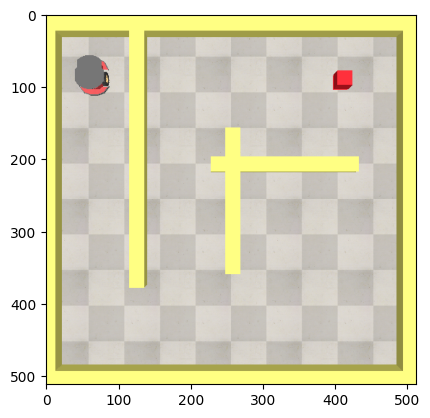

In [30]:
sim.startSimulation()
client.step()
time.sleep(1)
frame, resx, resy = camera.getFrame()
plt.imshow(frame)
sim.stopSimulation()
time.sleep(1)

Robot Position: [-1.89996676979519, -1.7004437028756394, 0.1386988909779436]
Robot Position in Image: 448.20149995632653 83.98234396543204
Estimated Robot Position [-1.89996677 -1.7004437   0.13869889]
Robot Position: [-1.9000340081643348, -1.700727748092153, 0.13870076841460277]
Robot Position in Image: 448.20837605119857 83.95354337811324
Estimated Robot Position [-1.90003401 -1.70072775  0.13870077]


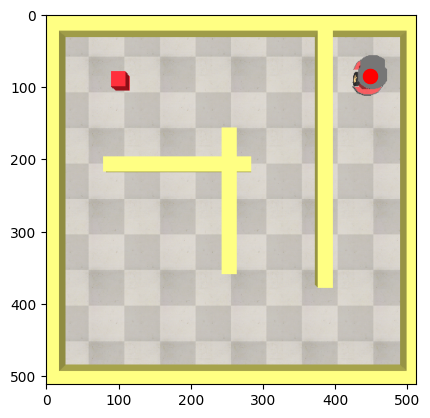

In [31]:
sim.startSimulation()
for _ in range(2):
    time.sleep(0.5)
    frame, resx, resy = camera.getFrame()
    cv2_frame= cv2.flip(frame, -1)
    cv2_frame= cv2.flip(cv2_frame, 0)
    robot_pos = sim.getObjectPosition(robot_gps_handle, -1)
    print('Robot Position:', robot_pos)
    u,v = world_to_pixel_coordinates(camera, robot_pos[0], robot_pos[1], robot_pos[2])
    print('Robot Position in Image:', u, v)
    # Distance from camera to robot
    # recompute p_c (or reuse it if you stored it) to get Z_c
    p_w = np.array(robot_pos).reshape(3,1)
    p_c = R_wc @ p_w + t_wc
    depth = p_c[2,0]    # <-- the *true* Z_c in camera frame

    print("Estimated Robot Position", pixel_to_world_coordinates(camera, (u,v), depth))

    plt.scatter(u, v, color='red', s=100, label='Robot Position in Image')
    plt.imshow(cv2_frame)
    client.step()
sim.stopSimulation()

In [32]:
#client.setStepping(True)
#sim.startSimulation()


# time.sleep(0.5)  # esperar medio segundo antes de la primera lectura